# A journey Through GSoC

In [3]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from time import sleep
from requests_html import HTMLSession

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams.update({'font.size': 13})

In [365]:
def annotate_barplot(ax):
    for p in ax.patches:
        val = f"{p.get_height():0.1f}"
        xpos = p.get_x()
        ypos = p.get_height() * 1.05
        ax.annotate(val, (xpos, ypos))

def extract_report(start_date, end_date, project_id, api_token, page=1):
    url_details = "https://api.track.toggl.com/reports/api/v2/details"
    params = {
        "user_agent": mail,
        "workspace_id": workspace_id,
        "since": start_date,
        "until": end_date,
        "page": page,
        "project_ids": project_id
    }
    r = requests.get(url_details, params=params, auth=(api_token, "api_token"))
    r.raise_for_status()
    
    return r

In [10]:
api_token = os.environ["TOGGL_API_TOKEN"]
password = os.environ["TOGGL_PASSWORD"]
mail = "g.duran@me.com"

In [12]:
headers = {
    "Content-Type": "application/json"
}

In [13]:
url_me = "https://api.track.toggl.com/api/v8/me"
r = requests.get(url_me, headers=headers, auth=(mail, password))
data = r.json()["data"]
print(data["fullname"], data["created_at"])

Gerardo Durán 2015-04-28T02:55:50+00:00


## Get workspaces

In [20]:
[(el["name"], el["id"]) for el in r.json()]

[('Personal', 921814),
 ('QMUL', 4657976),
 ('Sapienza', 4666718),
 ('Default Workspace', 5608619)]

In [14]:
url_workspace = "https://api.track.toggl.com/api/v8/workspaces"
r = requests.get(url_workspace, headers=headers, auth=(mail, password))
workspace_id = r.json()[0]["id"]
workspace_id

921814

## Get workspace projects

In [21]:
url_projects = f"https://api.track.toggl.com/api/v8/workspaces/{workspace_id}/projects"
r = requests.get(url_projects, headers=headers, auth=(mail, password))

ml_project, *_ = [project for project in r.json() if project["name"] == "GSoC"]
ml_project

{'id': 168628634,
 'wid': 921814,
 'name': 'GSoC',
 'billable': False,
 'is_private': True,
 'active': True,
 'template': False,
 'at': '2021-07-08T14:13:55+00:00',
 'created_at': '2021-03-29T19:49:57+00:00',
 'color': '8',
 'auto_estimates': False,
 'actual_hours': 397,
 'hex_color': '#465bb3'}

## My Time Entries

In [157]:
# Kick-off meeting to date of analysis
time_ranges = ["2021-05-24", "2021-08-15"]
time_ranges = [(init, end) for init, end in zip(time_ranges[:-1], time_ranges[1:])]

In [159]:
total_entries = []
for start_date, end_date in tqdm(time_ranges):
    info = extract_report(start_date, end_date, ml_project["id"], api_token).json()
    entries, per_page_entries = info["total_count"], info["per_page"]
    n_pages = entries // per_page_entries + 1
    total_entries.extend(info["data"])
    sleep(1)
    for page in tqdm(range(2, n_pages + 1), leave=False):
        info = extract_report(start_date, end_date, ml_project["id"], api_token, page=page).json()
        total_entries.extend(info["data"])
        sleep(1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [160]:
len(total_entries)

332

# GSoC

In [161]:
gsoc = pd.DataFrame(total_entries).set_index("start")
# gsoc = gsoc[gsoc.description.str.contains("^[Bb]ishop")].sort_index()
gsoc.index = pd.to_datetime(gsoc.index, utc=True).tz_convert("Europe/London")
gsoc = gsoc.sort_index()
gsoc.head()

,id,pid,tid,uid,description,end,updated,dur,user,use_stop,client,project,project_color,project_hex_color,task,billable,is_billable,cur,tags
start,,,,,,,,,,,,,,,,,,,
2021-05-24 15:26:30+01:00,2023310839,168628634,None,1670359,Kick off meeting,2021-05-24T16:41:18+01:00,2021-05-24T21:24:10+01:00,4488000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[meetings]
2021-05-24 21:28:34+01:00,2023834170,168628634,None,1670359,Issue #61,2021-05-24T21:34:44+01:00,2021-05-24T21:34:45+01:00,370000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming]
2021-05-24 22:30:54+01:00,2023900016,168628634,None,1670359,Issue #20,2021-05-25T00:03:36+01:00,2021-05-25T00:03:36+01:00,5562000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming]
2021-05-25 10:20:45+01:00,2024578414,168628634,None,1670359,Mails,2021-05-25T10:30:04+01:00,2021-05-25T10:30:05+01:00,559000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[management]
2021-05-25 15:35:56+01:00,2025172276,168628634,None,1670359,Daily meeting,2021-05-25T16:06:46+01:00,2021-05-25T17:18:02+01:00,1850000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[meetings]


## Temporal Analysis

In [162]:
# Date of the first time entry
gsoc.index.min().strftime("%Y-%m-%d")

'2021-05-24'

In [163]:
# Total time of tracked worked 
days_study = gsoc.index.max() - gsoc.index.min()
days_study

Timedelta('82 days 03:37:25')

In [164]:
# Total number of hours worked
gsoc["clocked_hours"] = gsoc["dur"] * 0.001 / 60 ** 2
total_hours = gsoc["clocked_hours"].sum()
total_hours

392.804835

In [167]:
gsoc["description"] = gsoc["description"].str.lower()
gsoc["description"]

start
2021-05-24 15:26:30+01:00    kick off meeting
2021-05-24 21:28:34+01:00           issue #61
2021-05-24 22:30:54+01:00           issue #20
2021-05-25 10:20:45+01:00               mails
2021-05-25 15:35:56+01:00       daily meeting
                                   ...       
2021-08-14 07:18:11+01:00          issue #358
2021-08-14 09:30:33+01:00          issue #358
2021-08-14 16:17:33+01:00          issue #358
2021-08-14 17:55:18+01:00          issue #358
2021-08-14 19:03:55+01:00          issue #358
Name: description, Length: 332, dtype: object

In [326]:
clocked_hours = (gsoc[["description", "clocked_hours"]]
                      .groupby("description")
                       .sum()
                       .sort_values("clocked_hours", ascending=False))
clocked_hours.head()

,clocked_hours
description,
daily meeting,52.231111
issue #54,38.633056
issue #279,30.807500
issue #40,27.674722
issue #299,18.192778


In [327]:
# Time working on issues
map_issues = clocked_hours.index.str.contains("#")
clocked_hours[map_issues].sum() / total_hours

clocked_hours    0.754195
dtype: float64

In [330]:
clocked_hours[map_issues].head()

,clocked_hours
description,
issue #54,38.633056
issue #279,30.807500
issue #40,27.674722
issue #299,18.192778
issue #311,15.647778


### Total time

<AxesSubplot:ylabel='Count'>

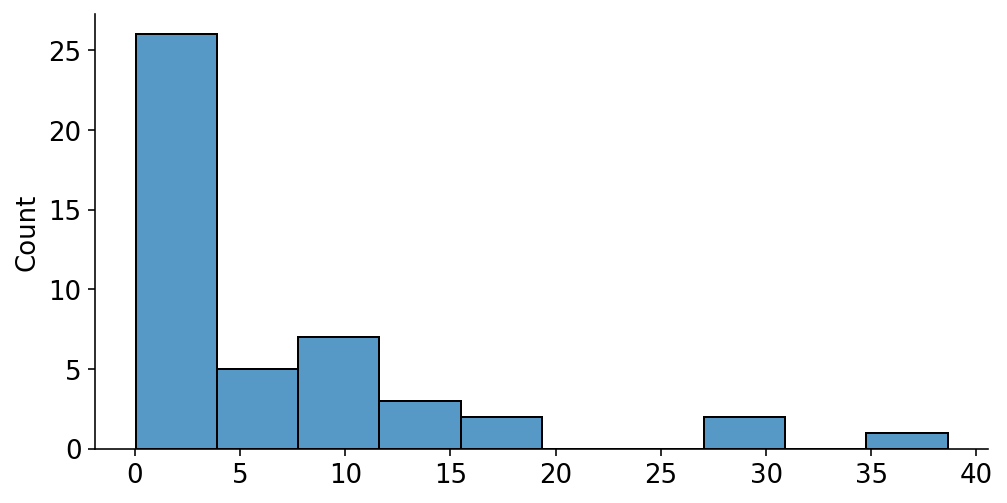

In [171]:
sns.histplot(clocked_hours[map_issues].values.ravel(), bins=10)

In [172]:
gsoc.resample("W")["clocked_hours"].sum()

start
2021-05-30 00:00:00+01:00    23.183056
2021-06-06 00:00:00+01:00    43.937778
2021-06-13 00:00:00+01:00    39.890833
2021-06-20 00:00:00+01:00    28.637222
2021-06-27 00:00:00+01:00    34.411111
2021-07-04 00:00:00+01:00     8.668333
2021-07-11 00:00:00+01:00    39.891111
2021-07-18 00:00:00+01:00    26.115556
2021-07-25 00:00:00+01:00    36.937222
2021-08-01 00:00:00+01:00    35.834722
2021-08-08 00:00:00+01:00    42.378611
2021-08-15 00:00:00+01:00    32.919279
Freq: W-SUN, Name: clocked_hours, dtype: float64

In [188]:
# Weekly commitment
gsoc.resample("W")["clocked_hours"].sum().mean()

32.73373625

In [184]:
gsoc.resample("M")["clocked_hours"].sum()

start
2021-05-31 00:00:00+01:00     30.657222
2021-06-30 00:00:00+01:00    144.213333
2021-07-31 00:00:00+01:00    142.636389
2021-08-31 00:00:00+01:00     75.297891
Freq: M, Name: clocked_hours, dtype: float64

<AxesSubplot:xlabel='start'>

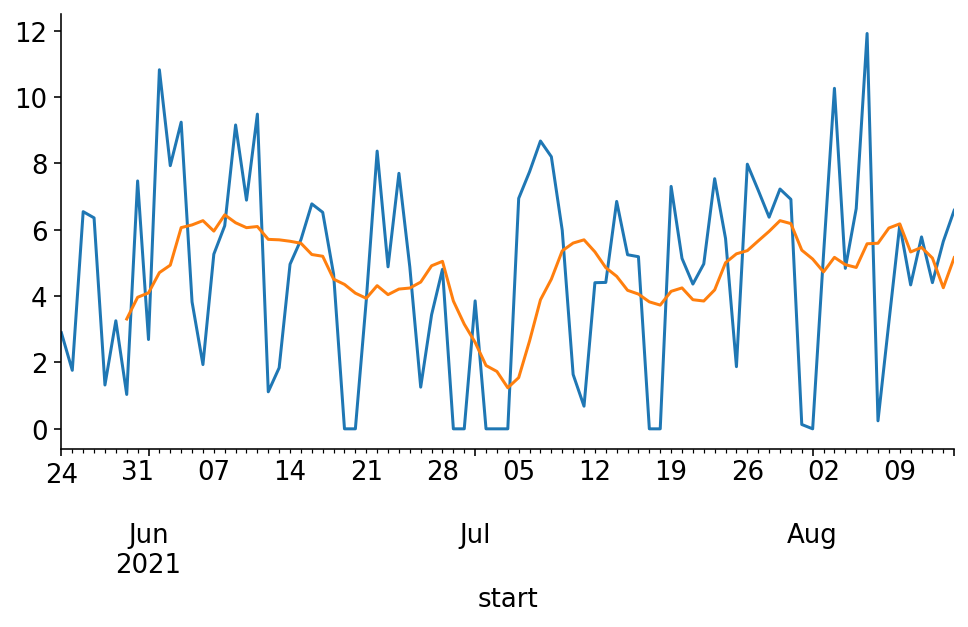

In [200]:
gsoc.resample("D")["clocked_hours"].sum().plot()
gsoc.resample("D")["clocked_hours"].sum().rolling(7).mean().plot()

In [279]:
daily = gsoc.resample("D")[["clocked_hours"]].sum()
hours_per_weekday = daily.assign(weekday=daily.index.weekday).groupby("weekday")["clocked_hours"]
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

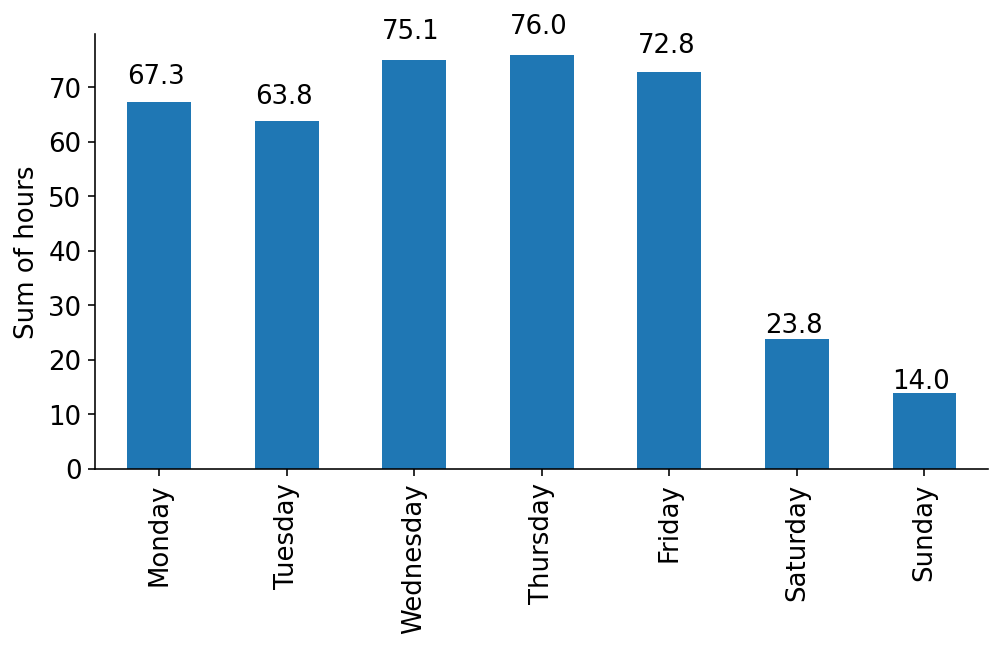

In [366]:
sum_hours_per_weekday = hours_per_weekday.sum()
sum_hours_per_weekday.index = weekdays
ax = sum_hours_per_weekday.plot(kind="bar")
annotate_barplot(ax)
ax.set_ylabel("Sum of hours");

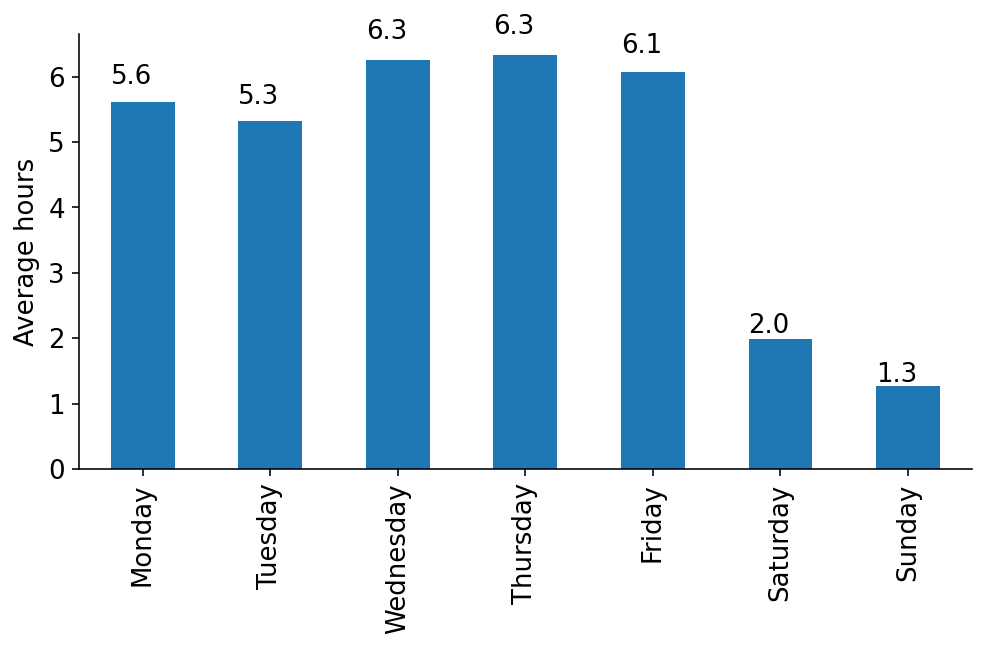

In [367]:
mean_hours_per_weekday = hours_per_weekday.mean()
mean_hours_per_weekday.index = weekdays
ax = mean_hours_per_weekday.plot(kind="bar")
annotate_barplot(ax)
ax.set_ylabel("Average hours");

In [368]:
start_values = gsoc.reset_index()[["start", "clocked_hours"]]
start_values["weekday"] = start_values["start"].apply(lambda v: v.weekday())
start_values["time"] = start_values["start"].apply(lambda v: v.hour + v.minute / 60)

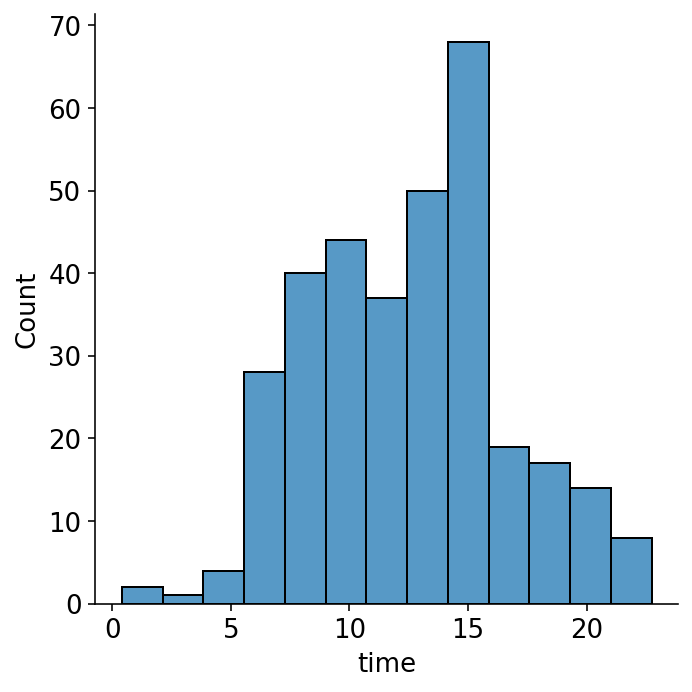

In [369]:
sns.displot(start_values, x="time")

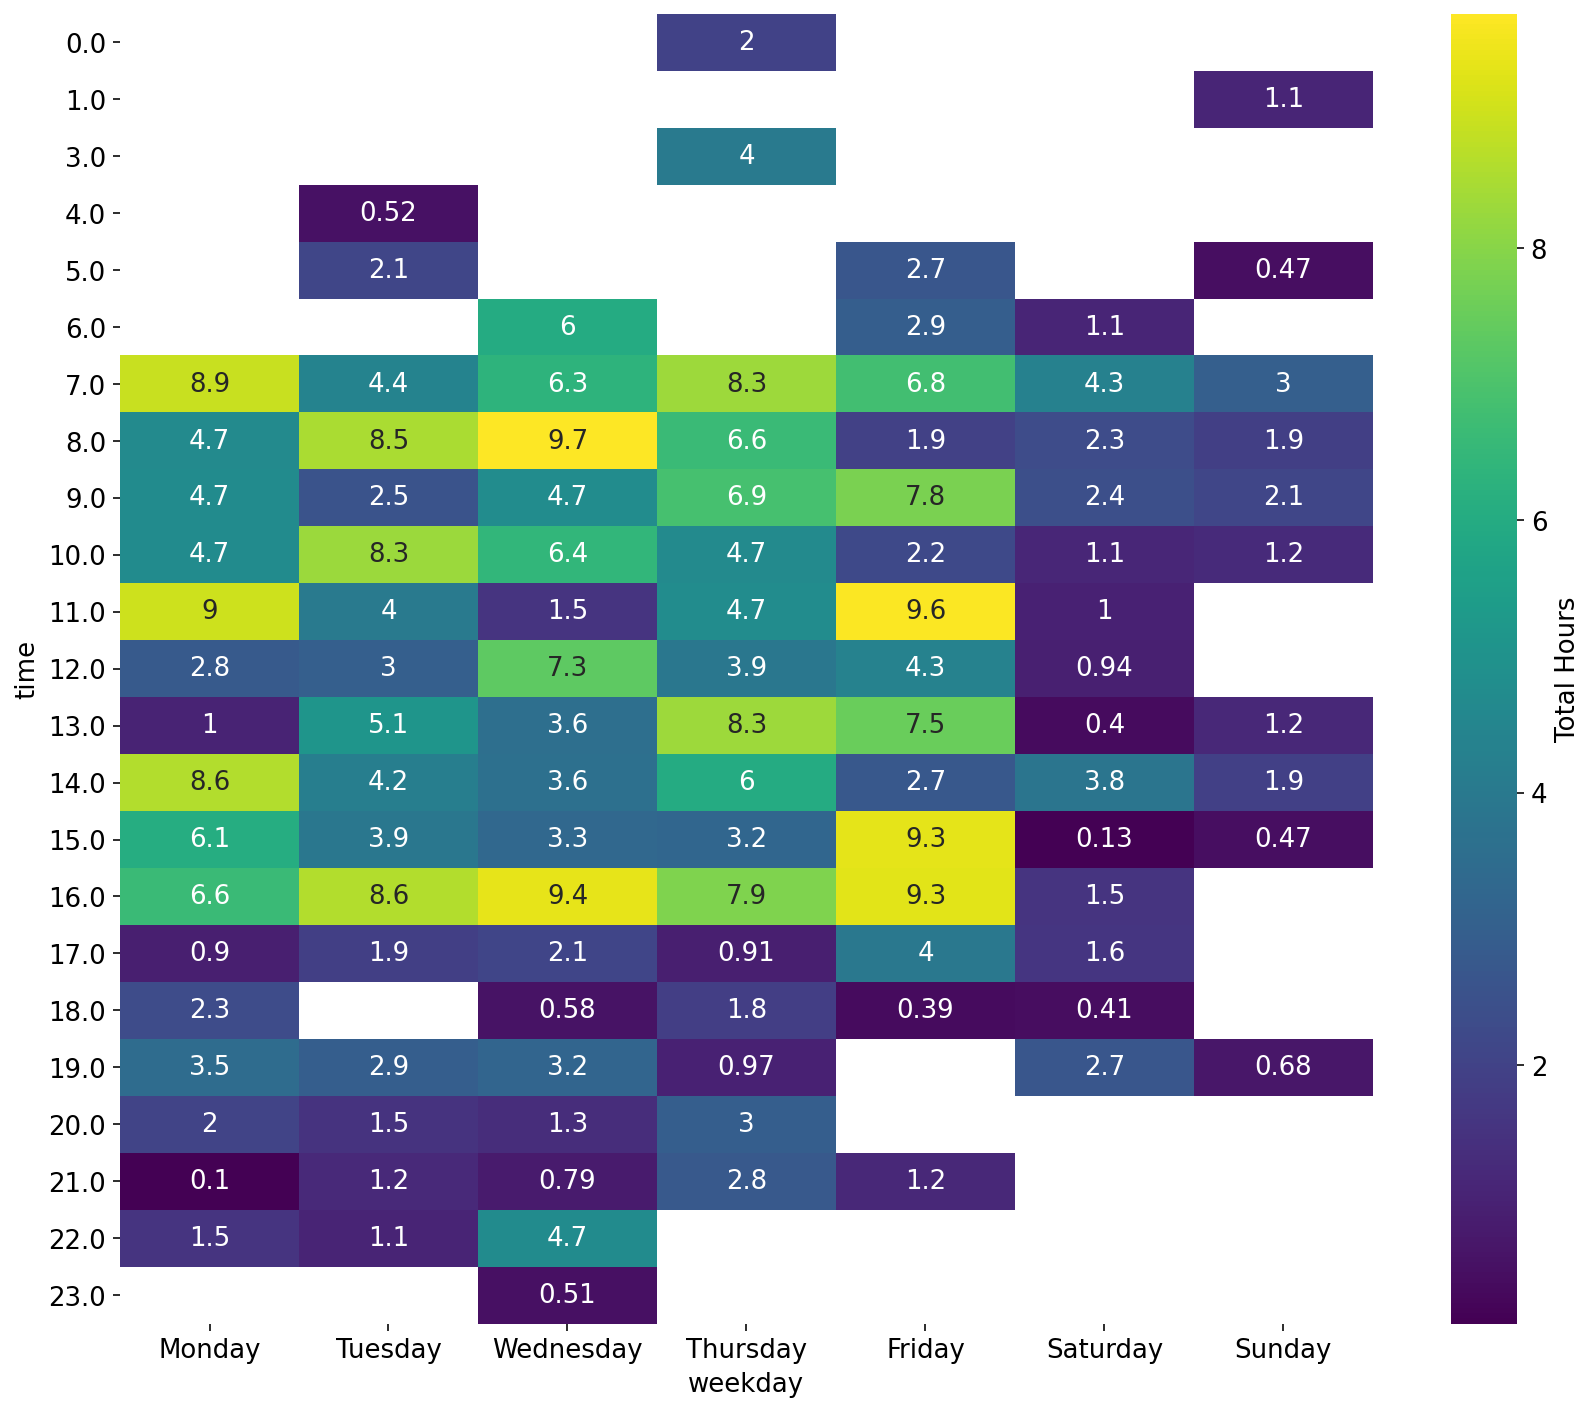

In [370]:
stime_distribution = (start_values.assign(time=start_values.time.round(0))
                                 .pivot_table(columns="weekday", index="time",
                                              values="clocked_hours", aggfunc="sum"))
time_distribution
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(time_distribution, annot=True, cmap="viridis",
            xticklabels=weekdays, cbar_kws={"label": "Total Hours"})
plt.tight_layout()

## Issue analysis

In [390]:
gsoc_issues = gsoc[gsoc.description.str.contains("#")]
gsoc_issues = gsoc_issues[["description", "clocked_hours"]]
issues_names = gsoc_issues.description.unique()
gsoc_issues

,description,clocked_hours
start,,
2021-05-24 21:28:34+01:00,issue #61,0.102778
2021-05-24 22:30:54+01:00,issue #20,1.545000
2021-05-26 13:13:08+01:00,issue #39,1.426944
2021-05-26 14:54:03+01:00,issue #39,0.252222
2021-05-26 16:08:15+01:00,issue #39,2.039722
...,...,...
2021-08-14 07:18:11+01:00,issue #358,1.910000
2021-08-14 09:30:33+01:00,issue #358,1.140556
2021-08-14 16:17:33+01:00,issue #358,1.536111


<AxesSubplot:xlabel='description'>

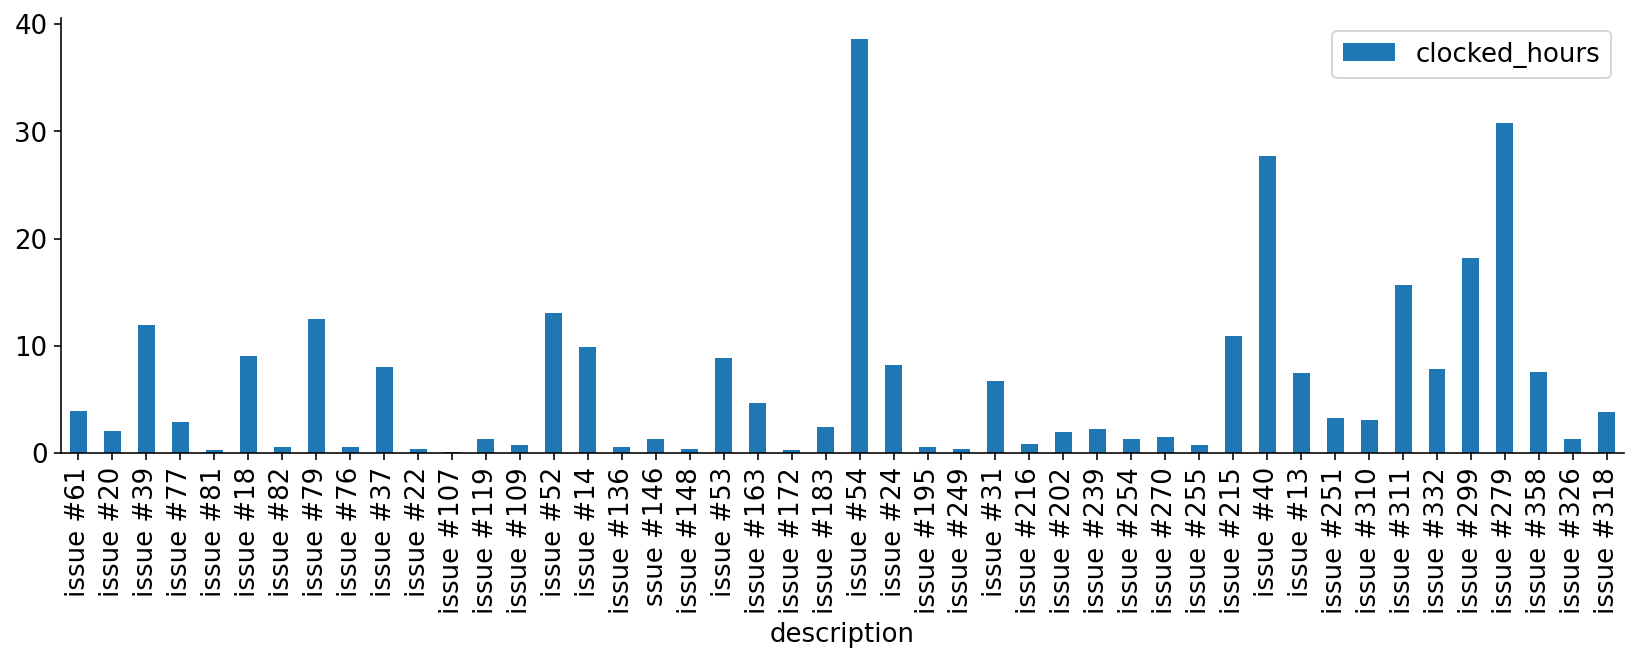

In [402]:
fig, ax = plt.subplots(figsize=(14, 4))
gsoc_issues.groupby("description").sum().reindex(issues_names).plot(kind="bar", ax=ax)

### Analysis of issues

## References
* [Detailed Report](https://github.com/toggl/toggl_api_docs/blob/master/reports/detailed.md)
* [Toggl Reports](https://github.com/toggl/toggl_api_docs/blob/master/reports.md)